# Task 5 - Lineare Kryptoanalyse

In [17]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## 1. SPN implementieren

In [18]:
class SPN:

    s_box = [0xE, 0x4, 0xD, 0x1, 0x2, 0xF, 0xB, 0x8, 0x3, 0xA, 0x6, 0xC, 0x5, 0x9, 0x0, 0x7]
    perms = [0, 4, 8, 12, 1, 5, 9, 13, 2, 6, 10, 14, 3, 7, 11, 15]

    # Richtig abgeschrieben?
    assert sum(perms) == sum(range(16))

    def __init__(self, key = 0):
        self.key = key

    def __substitution(self, val, inv=False):
        new_val = 0
        # Substituiere blockweise
        for b in range(4):
            block = (val >> (4 * b)) & 0xf
            sub = SPN.s_box.index(block) if inv else SPN.s_box[block]
            new_val ^= sub << (4 * b)
        return new_val
    
    def __permutation(self, val):
        new_val = 0
        # Permutiere bitweise
        for b in range(16):
            bit = val & 0x1
            new_val ^= bit << SPN.perms[b]
            val >>= 1
        return new_val
    
    def forward(self, val):
        for i in range(3):
            # Key Addition
            val ^= self.key
            val = self.__substitution(val)
            val = self.__permutation(val)
        val ^= self.key
        val = self.__substitution(val)
        val ^= self.key
        return val
    
    def back_to_u4(self, cryptotext, custom_key):
        return self.__substitution(cryptotext ^ custom_key, inv=True)

            


In [19]:
spn = SPN(random.getrandbits(16))
# Substitution Test
assert spn._SPN__substitution(0x15CD) == 0x4F59
assert spn._SPN__substitution(0x4F59, inv=True) == 0x15CD
# Ist Substitution reversibel?
assert np.all([spn._SPN__substitution(spn._SPN__substitution(val), inv=True) == val for val in range(16)])

## 2. Klartext-Kryptotext-Paare generieren

In [20]:
# Klartext-Kryptotext-Paare (M-C-Paare) generieren

random_pairs = True
if random_pairs:
    num_pairs = 8000 # max: 2^16 = 65536
    M = [random.getrandbits(16) for i in range(num_pairs)]
else:
    M = [i for i in range(0, 2 ** 16, 2 ** 3)]
    num_pairs = len(M)
C = [spn.forward(m) for m in M]
print(num_pairs)


8000


## 3. Lineare Kryptoanalyse
Wir testen alle möglichen Schlüsselbits im zweiten und vierten Block. Die Schlüsselbits, für die der Erwartungswert der linearen Approximation über alle Klartext-Kryptotext-Paare am stärksten von 0.5 abweicht, sind wahrscheinlich die richtigen.

In [21]:
# Bit an Stelle
def bit_at(val, bit):
    return (val >> (16 - bit)) & 0x1

# Konvertiere 2-block key in 4-block key (mit 1., 3. Block Nullen)
def expand_key(key_2blocks):
    return ((key_2blocks & 0xf0) << 4) ^ (key_2blocks & 0xf)

In [22]:
def lca_analyze(M, C):
    assert len(M) == len(C)
    key_hits = np.zeros(2 ** 8, dtype=np.int)

    # Lineare Kryptoanalyse: Wir probieren auf 8 bit
    for key_2blocks in tqdm(range(2 ** 8)):
        # Baue key aus den gegebenen 2 Blocks
        key = expand_key(key_2blocks)
        for m, c in zip(M, C):
            # Output Vektor
            u = spn.back_to_u4(c, key)
            # Berechne Wert der linearen Approximation
            val = bit_at(m, 5) ^ bit_at(m, 7) ^ bit_at(m, 8) ^ bit_at(u, 6) ^ bit_at(u, 8) ^ bit_at(u, 14) ^ bit_at(u, 16)
            if val == 0:
                key_hits[key_2blocks] += 1
    return np.abs(key_hits / len(M) - 0.5)


In [23]:
key_scores = lca_analyze(M, C)

Bester Score: 0.035375000000000045 at key 0xf0d
Echter Key: 0x429d
Score für echten Key: 0.033999999999999975 (#2 von 256)


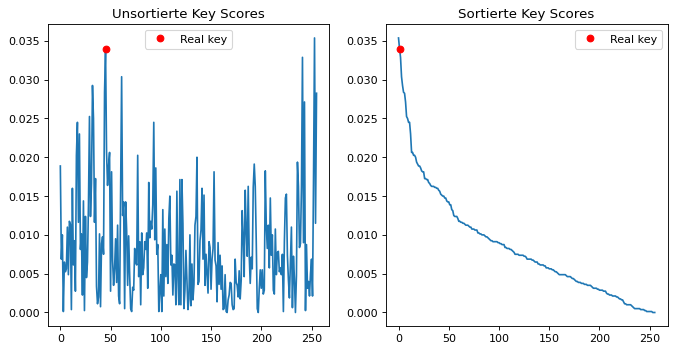

In [24]:
best_keys = np.argsort(key_scores)[::-1]
print("Bester Score:", key_scores[best_keys[0]], "at key", hex(expand_key(best_keys[0])))
print("Echter Key:", hex(spn.key))
real_key_2blocks = ((spn.key & 0xf00) >> 4) ^ (spn.key & 0xf)
print("Score für echten Key:", key_scores[real_key_2blocks], f"(#{np.where(best_keys == real_key_2blocks)[0][0]+1} von {key_scores.shape[0]})")

# Visualisierung

plt.figure(figsize=(10, 5), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(key_scores)), key_scores)
plt.plot(real_key_2blocks, key_scores[real_key_2blocks], "ro", label="Real key")
plt.legend()
plt.title("Unsortierte Key Scores")
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(key_scores)), key_scores[best_keys])
plt.plot(np.where(best_keys == real_key_2blocks)[0][0], key_scores[real_key_2blocks], "ro", label="Real key")
plt.legend()
plt.title("Sortierte Key Scores")
plt.show()

Der echte Key liegt meist auf den ersten 10 Plätzen.

## 4. Brute Force
Wir führen Brute Force über die noch unbekannten Blöcke 1 und 3 aus.

In [26]:
# Gibt true zurück, falls ein SPN mit key aus M erfolgreich C generiert
def check_key(key, M, C):
    spn = SPN(key)
    for m, c in zip(M, C):
        if spn.forward(m) != c:
            return False
    return True

# Teste für realen und für falschen Key
assert check_key(spn.key, M, C)
assert not check_key(spn.key + 1, M, C)

# Gegeben Block 2 und 4 sowie Block 1 und 3, baue 4-block Schlüssel zusammen
def mix_2blocks(block24, block13):
    return ((block24 & 0xf0) << 4) ^ (block24 & 0xf) ^ ((block13 & 0xf0) << 8) ^ ((block13 & 0xf) << 4)

# Führe Brute Force auf 1. und 3. Block aus (Block 2, 4 durch LCA bekannt)
def brute_force_key(known_2blocks, M, C):
    for unknown_2blocks in range(2 ** 8):
        key = mix_2blocks(known_2blocks, unknown_2blocks)
        if check_key(key, M, C):
            return key
    return None

# Funktioniert Brute Force?
assert brute_force_key(real_key_2blocks, M, C) == spn.key

## 5. Alles zusammen

In [27]:
# Finde den Key, der genutzt wurde, um mit einem SPN C aus M zu generieren
def find_key(M, C):
    key_scores = lca_analyze(M, C)
    best_keys = np.argsort(key_scores)[::-1]
    for known_2blocks in best_keys:
        key = brute_force_key(known_2blocks, M, C)
        if key is not None:
            return key
    return None

In [28]:
found_key = find_key(M, C)
print("found key:", hex(found_key))


found key: 0x429d


## 6. Nur Brute Force

In [29]:
def pure_brute_force_key(M, C):
    for key in tqdm(range(2**16)):
        if check_key(key, M, C):
            return key
    return None

In [30]:
found_key = pure_brute_force_key(M, C)
print("found key:", hex(found_key))

found key: 0x429d


Wie erwartet ist Brute Force in diesem primitiven SPN (mit kleiner Schlüsselgröße von 16 bit) um Größenordnungen schneller als die lineare Kryptoanalyse.